In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/MyDrive/NN_MEFs/

 CAISO_Data_2019_2021_NN_Ts.csv   FF_models     MLP_MEFs.ipynb
'Experiment notes.gdoc'		  lstm_models   mlp_non_bottleneck_models


## Parameters

In [4]:
work_dir = "drive/MyDrive/NN_MEFs"
data_file = f"{work_dir}/CAISO_Data_2019_2021_NN_Ts.csv"
model_save_dir = f"{work_dir}/lstm_models"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading and pre-processing

In [5]:
def get_num_examples_in_block(block_len, seq_len):
    return max(block_len - seq_len + 1, 0)

def get_num_examples_in_data(block_len, seq_len, total_size):
    num_full_blocks = total_size // block_len
    block_remainder = total_size % block_len
    num_examples = num_full_blocks * get_num_examples_in_block(block_len, seq_len) \
                 + get_num_examples_in_block(block_remainder, seq_len)
    return num_examples

seq_len = 24
block_len = 3 * 24  # chunk data in blocks of 3 days for splitting to train/val/test
total_size = 24 * 365 * 3 + 24
print(f"num examples for seq_len=24, block_len=2*24: {get_num_examples_in_data(2*24, 24, total_size)}")
print(f"num examples for seq_len=24, block_len=3*24: {get_num_examples_in_data(3*24, 24, total_size)}")
print(f"num examples for seq_len=12, block_len=2*24: {get_num_examples_in_data(2*24, 12, total_size)}")
print(f"num examples for seq_len=12, block_len=3*24: {get_num_examples_in_data(3*24, 12, total_size)}")
print(f"num examples for seq_len=3, block_len=2*24: {get_num_examples_in_data(2*24, 3, total_size)}")
print(f"num examples for seq_len=3, block_len=3*24: {get_num_examples_in_data(3*24, 3, total_size)}")
print(f"num examples for seq_len=8, block_len=1*24: {get_num_examples_in_data(1*24, 8, total_size)}")

num examples for seq_len=24, block_len=2*24: 13700
num examples for seq_len=24, block_len=3*24: 17886
num examples for seq_len=12, block_len=2*24: 20276
num examples for seq_len=12, block_len=3*24: 22278
num examples for seq_len=3, block_len=2*24: 25208
num examples for seq_len=3, block_len=3*24: 25572
num examples for seq_len=8, block_len=1*24: 18632


We will try 6:2:2 day-blocks and sequence length of 8 first. 

In [6]:
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)

# Adding some temporal features
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]

num_samples = len(CAISO_Data)

# create train, validation and test data
data_sets = {"train": {"days_in_block": 6}, "val": {"days_in_block": 2}, "test": {"days_in_block": 2}}
seq_len = 8
for data in data_sets.values():
    data["block_len"] = data["days_in_block"] * 24 + seq_len - 1
set_assignments = []
remaining_samples_to_assign = num_samples
cur_set_idx = 0
set_names = list(data_sets.keys())
while remaining_samples_to_assign:
    cur_set = set_names[cur_set_idx]
    samples_to_assign = min(remaining_samples_to_assign, data_sets[cur_set]["block_len"])
    set_assignments.extend([cur_set for i in range(samples_to_assign)])

    cur_set_idx = (cur_set_idx + 1) % len(set_names)
    remaining_samples_to_assign -= samples_to_assign

set_assignments = np.array(set_assignments)
for set_name, data in data_sets.items():
    data["mask"] = set_assignments == set_name

points_in_last_assignment = 0
while set_assignments[-(points_in_last_assignment + 1)] == set_assignments[-1]:
    points_in_last_assignment += 1
last_assignment_set = set_assignments[-1]
print(f"The last block of points assigned is in the {last_assignment_set} set and has {points_in_last_assignment/24} day(s) of points.")

for set_name, data in data_sets.items():
    print(f"number of points in {set_name} set: {sum(data['mask'])}")


## Specify features to use
# feature_cols = ['Load', 'VRE', 'Hour', 'Month', 'Day', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Is_Weekend', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols.extend([f"Day_of_Week={day_of_week}" for day_of_week in range(7)])

feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
# feature_cols.extend([f"Load_t-{i}" for i in prev_time_steps] + [f"VRE_t-{i}" for i in prev_time_steps])
# feature_cols.extend(["Load_d1", "Load_d2", "VRE_d1", "VRE_d2"])
# feature_cols.extend(["delta_Load", "delta_VRE"])


# specify x, bottleneck features, and y data
bottleneck_feature_cols = ["delta_Load", "delta_VRE"]
y_col = 'delta_Total_CO2_Emissions'

for set_name, data in data_sets.items():
    CAISO_subset = CAISO_Data.loc[data["mask"]]
    data["X"] = CAISO_subset[feature_cols].values.astype(np.float32)
    data["y"] = CAISO_subset[y_col].values.astype(np.float32)
    data["bottleneck_X"] = CAISO_subset[bottleneck_feature_cols].values.astype(np.float32)

# standardize data based on mean and variance of train data
scaler = preprocessing.StandardScaler()
scaler.fit(data_sets["train"]["X"])
for data in data_sets.values():
    data["X"] = scaler.transform(data["X"])

# seperate data to contiguous blocks
def reshape_to_blocks(arr, block_size):
    block_arr = []
    start_pos = 0
    while start_pos < len(arr):
        end = min(start_pos + block_size, len(arr))
        block_arr.append(arr[start_pos: end])
        start_pos = end
    return block_arr

def split_blocks_to_seqs(blocks, seq_len=seq_len):
    """
    blocks: num_blocks x block_len [x features]

    ret:
      seqs: num_seqs x seq_len [x features]
    """
    seqs = []
    for block in blocks:
        block_len = len(block)
        assert block_len >= seq_len
        seqs.extend([block[start: start+seq_len] for start in range(block_len - seq_len)])
    return np.array(seqs)

# split data to contiguous blocks, and expand to example sequences via sliding window over blocks
for data in data_sets.values():
    for key in ["X", "y", "bottleneck_X"]:
        data[key] = reshape_to_blocks(data[key], data["block_len"])
        data[key] = split_blocks_to_seqs(data[key], seq_len)
        data[key] = torch.tensor(data[key]).to(device)

print(f"\nAfter splitting blocks to example sequences:")
total_examples = sum(len(data["X"]) for data in data_sets.values())
for set_name, data in data_sets.items():
    print(f"Number of example sequences in {set_name} set: {len(data['X'])} ({100*len(data['X'])/total_examples:.1f}%)")

The last block of points assigned is in the val set and has 2.2083333333333335 day(s) of points.
number of points in train set: 15251
number of points in val set: 5553
number of points in test set: 5500

After splitting blocks to example sequences:
Number of example sequences in train set: 14443 (60.5%)
Number of example sequences in val set: 4745 (19.9%)
Number of example sequences in test set: 4700 (19.7%)


In [7]:
data_sets["train"]["y"].shape

torch.Size([14443, 8])

In [8]:
data_sets["train"]["X"].shape

torch.Size([14443, 8, 4])

## define model and set params

In [9]:
def get_model(n_input, hidden_dim, n_out, dropout_p):
    
    layers = [nn.lstm(input_size=n_input, hidden_size=hidden_dim,
                      batch_first=True, proj_size=n_out, num_layers=1),
             ]
    
    model = nn.Sequential(*layers)
    return model

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 final_point_only, num_layers=1, dropout=0, debug=False):
        super().__init__()
        self.final_point_only = final_point_only
        self.debug = debug
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            batch_first=True, num_layers=num_layers, dropout=dropout)
        self.batchnorm1d = nn.BatchNorm1d(hidden_size)
        # self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        lstm_out, (hn, cn) = self.lstm(input_seq)
        if self.final_point_only:
            lstm_out = torch.unsqueeze(lstm_out[:,-1,:], 1) # batch x seq_len x hidden
        lstm_out = self.batchnorm1d(lstm_out.permute(0,2,1)) # batch x hidden x seq_len is needed as input
        lstm_out = lstm_out.permute(0, 2, 1) # switch hidden and seq_len dims back
        # lstm_out = self.dropout(lstm_out)
        fc_out = self.fc(lstm_out)
        if self.debug:
            print(f"lstm_out: {lstm_out}")
            print(f"hn: {hn}")
            print(f"cn: {cn}")
            print(f"self.fc: {self.fc}")
            print(f"fc_out: {fc_out}")
        return fc_out

def get_y_pred(pred_coeff, bottleneck_X):

    MEF_preds = pred_coeff[:,:,0]
    MDF_preds = pred_coeff[:,:,1]
    delta_load = bottleneck_X[:,:,0]
    delta_vre = bottleneck_X[:,:,1]
    y_pred_demand = torch.mul(delta_load, MEF_preds)
    y_pred_vre = torch.mul(delta_vre, MDF_preds)
    y_pred = y_pred_vre + y_pred_demand
    if pred_coeff.shape[-1] == 3:
        # we are using a linear model with an intercept term
        y_pred += pred_coeff[:,:,2]
    
    return y_pred

def mse_loss_l2_coeff_reg(pred_coeff, bottleneck_X, y, MEF_reg_weight, MDF_reg_weight):
    """
    pred_coeff: batch x seq_len x output_dim
    bottleneck_X: batch x seq_len x bottleneck_dim
    y: batch x seq_len
    """

    y_pred = get_y_pred(pred_coeff, bottleneck_X)

    MEF_preds = pred_coeff[:,:,0]
    MDF_preds = pred_coeff[:,:,1]

    # Compute MEF regularization term (sum(MEF^2 + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = torch.flatten(nn.functional.relu(-MEF_preds))  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 4420  # based on an average value of -65 seen amongst invalids when trained without regularization
    MEF_reg = torch.dot(invalid_MEFs, invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF^2 + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = torch.flatten(nn.functional.relu(MDF_preds))  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 538  # based on an average value of +23 seen amongst invalids when trained without regularization
    MDF_reg = torch.dot(invalid_MDFs, invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(y_pred, y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

def mse_loss_l1_coeff_reg(pred_coeff, bottleneck_X, y, MEF_reg_weight, MDF_reg_weight):
    """
    pred_coeff: batch x seq_len x output_dim
    bottleneck_X: batch x seq_len x bottleneck_dim
    y: batch x seq_len
    """
    y_pred = get_y_pred(pred_coeff, bottleneck_X)

    MEF_preds = pred_coeff[:,:,0]
    MDF_preds = pred_coeff[:,:,1]

    # Compute MEF regularization term (sum(MEF + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 66.5  # The average value seen amongst invalids when trained without regularization
    MEF_reg = torch.sum(invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 23.2  # The average value seen amongst invalids when trained without regularization
    MDF_reg = torch.sum(invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(y_pred, y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

## Model Training

Helpers for printing results

In [10]:
pd.options.mode.chained_assignment = None  # default='warn'

In [11]:
def plot_losses(train_losses, val_losses, plt_save_dir=None):
    # plot loss vs epochs
    fig, axs = plt.subplots(1,2)
    axs[0].plot(train_losses[50:])
    axs[0].set_title("Train Set")
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')

    axs[1].plot(val_losses[50:])
    axs[1].set_title("Val Set")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    
    plt.tight_layout()
    plt.show()
    
    if plt_save_dir:
        fig.savefig(f"{plt_save_dir}/train_val_losses.png") 

# Probably delete this
# def print_results(train_losses, train_pred_coeff, train_bottleneck_X, train_y,
#                   val_losses, val_pred_coeff, val_bottleneck_X, val_y, 
#                   plt_save_dir=None):
#     # plot loss vs epochs
#     fig, axs = plt.subplots(1,2)
#     axs[0].plot(train_losses[1:])
#     axs[0].set_title("Train Set")
#     axs[0].set_ylabel('loss')
#     axs[0].set_xlabel('epoch')

#     axs[1].plot(val_losses[1:])
#     axs[1].set_title("Val Set")
#     axs[1].set_ylabel('loss')
#     axs[1].set_xlabel('epoch')
    
#     plt.tight_layout()
#     plt.show()
    
#     if plt_save_dir:
#         fig.savefig(f"{plt_save_dir}/train_val_losses.png") 

#     train_y_pred = get_y_pred(train_pred_coeff, train_bottleneck_X)
#     val_y_pred = get_y_pred(val_pred_coeff, val_bottleneck_X)

#     # count number of invalid values predicted
#     invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
#     invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)

#     # calculate performance metrics
#     train_error = train_y_pred - train_y
#     print("Train Set:")
#     print(f"\tMean Emissions Change = {torch.mean(torch.abs(train_y)).item():.2f}")
#     print(f"\tMean Error = {torch.mean(torch.abs(train_error)).item():.2f}")
#     print(f"\tInvalid MEFs,MDFs = {invalid_train_MEFs},{invalid_train_MDFs}")
#     print(f"\tR Squared = {r2_score(train_y.cpu().detach().numpy(), train_y_pred.cpu().detach().numpy()):.4f}")
    
#     val_error = val_y_pred - val_y
#     print("Val Set:")
#     print(f"\tMean Emissions Change = {torch.mean(torch.abs(val_y)).item():.2f}")
#     print(f"\tMean Error = {torch.mean(torch.abs(val_error)).item():.2f}")
#     print(f"\tInvalid MEFs,MDFs = {invalid_val_MEFs},{invalid_val_MDFs}")
#     print(f"\tR Squared = {r2_score(val_y.cpu().detach().numpy(), val_y_pred.cpu().detach().numpy()):.4f}")
    
def get_r_squared(pred_coeff, bottleneck_X, y):
    y_pred = get_y_pred(pred_coeff, bottleneck_X)
    # only one element in sequence is being predicted, return single R2
    if y.shape[-1] == 1:
        return r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    # more than one elt in seq being predicted, return an R2 for each position that we could evaluate at
    else:
        return [r2_score(y_i, y_pred_i) for y_i, y_pred_i in \
                zip(y.permute(1,0).cpu().detach().numpy(),
                    y_pred.permute(1,0).cpu().detach().numpy())]

def get_mean_abs_err(pred_coeff, bottleneck_X, y):
    y_pred = get_y_pred(pred_coeff, bottleneck_X)
    # only one element in sequence is being predicted, return single MAE
    if y.shape[-1] == 1:
        return mean_absolute_error(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
    # more than one elt in seq being predicted, return an MAE for each position that we could evaluate at
    else:
        return [mean_absolute_error(y_i, y_pred_i) for y_i, y_pred_i in \
                zip(y.permute(1,0).cpu().detach().numpy(),
                    y_pred.permute(1,0).cpu().detach().numpy())]

def get_count_invalid_preds(pred_coeff):
    count_neg_MEFs = torch.sum(pred_coeff[:,:,0] <= 0).item()  # MEF must be greater than 0
    count_pos_MDFs = torch.sum(pred_coeff[:,:,1] > 0).item()  # MDF must be less than or equal to 0
    return count_neg_MEFs, count_pos_MDFs

Train the model

In [12]:
def train_model_with_params_batched(train_X, val_X, train_bottleneck_X, val_bottleneck_X, train_y, val_y,  # data
                            input_size, hidden_size, output_size, final_point_only, num_layers, dropout,  # model settings
                            learning_rate, weight_decay,  # optimizer settings
                            loss_function, MEF_reg_weight, MDF_reg_weight,  # loss function settings
                            model_dir_prefix=None, batch_size=None, epochs=10000, # train process settings
                            print_freq=1000, min_save_r2=.87, max_save_mae=150000):  # train process settings

    if not batch_size:
        batch_size = len(train_X)

    # if predicting final point in sequence only, keep only those corresponding points
    # in the bottleneck_X and y arrays
    if final_point_only:
        train_bottleneck_X = torch.unsqueeze(train_bottleneck_X[:,-1,:], 1)
        val_bottleneck_X = torch.unsqueeze(val_bottleneck_X[:,-1,:], 1)
        train_y = torch.unsqueeze(train_y[:,-1], 1)
        val_y = torch.unsqueeze(val_y[:,-1], 1)

    # create model and optimizer
    model = LSTM(input_size, hidden_size, output_size, final_point_only, num_layers, dropout)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Set up folder where model and model info will be saved
    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir += f"/{model_dir_prefix}"
    model_dir += f"/{datetime.now().strftime('%Y_%m_%d-%I:%M:%S_%p')}"
    Path(model_dir).mkdir(parents=True, exist_ok=True)

    # log experiment settings
    settings_str = "Model Settings:"
    settings_str += f"\n\t{input_size=}\n\t{hidden_size=}\n\t{output_size=}\n\t{final_point_only=}\n\t{num_layers=}\n\t{dropout=}"
    settings_str += "\nOptimizer Settings:"
    settings_str += f"\n\t{learning_rate=}\n\t{weight_decay=}"
    settings_str += "\nLoss Function Settings:"
    settings_str += f"\n\t{loss_function=}\n\t{MEF_reg_weight=}\n\t{MDF_reg_weight=}"
    settings_str += "\nTrain Process Settings:"
    settings_str += f"\n\t{batch_size=}\n\t{epochs=}\n\t{min_save_r2=}\n\t{max_save_mae=}"
    settings_str += f"\nFeatures: {', '.join(feature_cols)}"
    print(settings_str)
    with open(f"{model_dir}/experiment_settings.txt", 'w+') as f:
        f.write(settings_str)

    # set up vars for keeping track of stats of best-seen models
    best_r2 = -np.inf
    best_r2_epoch = None
    best_mae = np.inf
    best_mae_epoch = None
    best_r2_model = {"r2": -np.inf}
    best_mae_model = {"mae": np.inf}
    if not final_point_only:
        best_r2_any_point = -np.inf
        best_r2_any_point_list = None
        best_mae_any_point = np.inf
        best_mae_any_point_list = None
    
    # train/eval loop
    train_losses = []
    val_losses = []
    batches_per_epoch = int(np.ceil(len(train_X) / batch_size))
    for epoch in tqdm(range(epochs)):
        if batches_per_epoch > 1:
            shuffle_perm = torch.randperm(len(train_X))
            train_X = train_X[shuffle_perm]
            train_bottleneck_X = train_bottleneck_X[shuffle_perm]
            train_y = train_y[shuffle_perm]

        # tell model we are training
        model.train()
        # make updates based on each batch in training data
        for batch in range(batches_per_epoch):
            batch_start, batch_end = batch * batch_size, (batch + 1) * batch_size
            batch_train_X = train_X[batch_start: batch_end]
            batch_train_bottleneck_X = train_bottleneck_X[batch_start: batch_end]
            batch_train_y = train_y[batch_start: batch_end]
        
            batch_train_pred_coeff = model(batch_train_X.float())
            batch_train_loss = loss_function(batch_train_pred_coeff, batch_train_bottleneck_X, batch_train_y, MEF_reg_weight, MDF_reg_weight)
            model.zero_grad()
            batch_train_loss.backward()
            optimizer.step()
        
        # tell model we are evaluating
        model.eval()

        # re-run on training data to get current train loss for the epoch
        train_pred_coeff = model(train_X.float())
        train_loss = loss_function(train_pred_coeff, train_bottleneck_X, train_y, MEF_reg_weight, MDF_reg_weight)
        train_losses.append(train_loss.item())

        # run on val data to evaluate how we are doing
        val_pred_coeff = model(val_X.float())
        val_loss = loss_function(val_pred_coeff, val_bottleneck_X, val_y, MEF_reg_weight, MDF_reg_weight)
        val_losses.append(val_loss.item())
        val_r2 = get_r_squared(val_pred_coeff, val_bottleneck_X, val_y)
        val_mae = get_mean_abs_err(val_pred_coeff, val_bottleneck_X, val_y)
        if not final_point_only:
            val_r2_list = val_r2
            val_mae_list = val_mae
            # evaluate on last point in sequence only
            val_r2 = val_r2[-1] 
            val_mae = val_mae[-1]
            # update best seen at any point in sequence
            val_r2_any_point = max(val_r2_list)
            if val_r2_any_point > best_r2_any_point:
                best_r2_any_point = val_r2_any_point
                best_r2_any_point_list = val_r2_list
            val_mae_any_point = min(val_mae_list) 
            if val_mae_any_point < best_mae_any_point:
                best_mae_any_point = val_mae_any_point
                best_mae_any_point_list = val_mae_list

        # always keep best r2 and mae updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_r2_epoch = epoch
        if val_mae < best_mae:
            best_mae = val_mae
            best_mae_epoch = epoch

        # check if we should save best r2 model
        if val_r2 > max(best_r2_model["r2"], min_save_r2):
            # only continue with saving if this model has no invalids
            if sum(get_count_invalid_preds(val_pred_coeff))==0 and sum(get_count_invalid_preds(train_pred_coeff))==0:
                # update best-r2-model stats
                best_r2_model["r2"] = val_r2
                best_r2_model["epoch"] = epoch
                best_r2_model["mae"] = val_mae
                if not final_point_only:
                    best_r2_model["seq-wise-r2"] = val_r2_list
                    best_r2_model["seq-wise-mae"] = val_mae_list
                # delete prev best-r2-model unless best-mae-model still points to it
                if "save_path" in best_r2_model \
                and ("save_path" not in best_mae_model \
                or best_r2_model["save_path"] != best_mae_model["save_path"]):
                    Path(best_r2_model["save_path"]).unlink() # delete prev-best model
                model_save_name = f"epoch={epoch},r2={val_r2:.4f},mae={int(val_mae)},Invalids=0.pth"
                save_model_path = f"{model_dir}/{model_save_name}"
                best_r2_model["save_path"] = save_model_path
                torch.save(model.state_dict(), save_model_path)

        # check if we should save best mae model
        if val_mae < min(best_mae_model["mae"], max_save_mae):
            # if we already saved best-r2-model on this round, then that model is our best mae model
            if epoch in best_r2_model and best_r2_model["epoch"] == epoch:
                best_mae_model["r2"] = val_r2
                best_mae_model["epoch"] = epoch
                best_mae_model["mae"] = val_mae
                if not final_point_only:
                    best_mae_model["seq-wise-r2"] = val_r2_list
                    best_mae_model["seq-wise-mae"] = val_mae_list
                # delete prev best-mae-model
                if "save_path" in best_mae_model:
                    Path(best_mae_model["save_path"]).unlink() # delete prev-best model
                best_mae_model["save_path"] = best_r2_model["save_path"]
            # Otherwise need to check again if this model has no invalids
            elif sum(get_count_invalid_preds(val_pred_coeff))==0 and sum(get_count_invalid_preds(train_pred_coeff))==0:
                # update best-mae-model stats
                best_mae_model["r2"] = val_r2
                best_mae_model["epoch"] = epoch
                best_mae_model["mae"] = val_mae
                if not final_point_only:
                    best_mae_model["seq-wise-r2"] = val_r2_list
                    best_mae_model["seq-wise-mae"] = val_mae_list
                # delete prev best-mae-model unless best-r2-model still points to it
                if "save_path" in best_mae_model \
                and ("save_path" not in best_r2_model \
                or best_r2_model["save_path"] != best_mae_model["save_path"]):
                    Path(best_mae_model["save_path"]).unlink() # delete prev-best model
                model_save_name = f"epoch={epoch},r2={val_r2:.4f},mae={int(val_mae)},Invalids=0.pth"
                save_model_path = f"{model_dir}/{model_save_name}"
                best_mae_model["save_path"] = save_model_path
                torch.save(model.state_dict(), save_model_path)

        # print performance info every so often
        if epoch % print_freq == 0:
            invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
            invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
            train_r2 = get_r_squared(train_pred_coeff, train_bottleneck_X, train_y)
            if not final_point_only:
                # evaluate on last point in sequence only
                train_r2 = train_r2[-1] 
            print(f"[Epoch {epoch}]")
            print(f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}, Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
            print(f"\tVal Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}, Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")

        # stop if we aren't improving after 10k epochs
        if best_r2_epoch and epoch > 10000 + best_r2_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break
    
    plot_losses(train_losses, val_losses, model_dir)

    results_str = f"Best R Squared seen on epoch {best_r2_epoch}: {best_r2:.4f}"
    results_str += f"\nBest MAE seen on epoch {best_mae_epoch}: {best_mae:.2f}"
    results_str += f"\nBest-R2-model with R2 above {min_save_r2=} and 0 invalid coefficients predicted on train/test sets:"
    if "save_path" not in best_r2_model:
        results_str += f"\n\tNo such model was encountered"
    else:
        results_str += f"\n\tValidation R2: {best_r2_model['r2']:.4f}"
        results_str += f"\n\tValidation MAE: {best_r2_model['mae']:.2f}"
        if not final_point_only:
            r2_str_list = [f"{val:.4f}" for val in best_r2_model['seq-wise-r2']]
            results_str += f"\n\tValidation sequence-wise-R2: {r2_str_list}"
            mae_str_list = [f"{val:.2f}" for val in best_r2_model['seq-wise-mae']]
            results_str += f"\n\tValidation sequence-wise-MAE: {mae_str_list}"
        results_str += f"\n\tEpoch seen: {best_r2_model['epoch']}"
        results_str += f"\n\tModel file: {best_r2_model['save_path'].split('/')[-1]}"
    results_str += f"\nBest-MAE-model with MAE below {max_save_mae=} and 0 invalid coefficients predicted on train/test sets:"
    if "save_path" not in best_mae_model:
        results_str += f"\n\tNo such model was encountered"
    else:
        results_str += f"\n\tValidation R2: {best_mae_model['r2']:.4f}"
        results_str += f"\n\tValidation MAE: {best_mae_model['mae']:.2f}"
        if not final_point_only:
            r2_str_list = [f"{val:.4f}" for val in best_mae_model['seq-wise-r2']]
            results_str += f"\n\tValidation sequence-wise-R2: {r2_str_list}"
            mae_str_list = [f"{val:.2f}" for val in best_mae_model['seq-wise-mae']]
            results_str += f"\n\tValidation sequence-wise-MAE: {mae_str_list}"
        results_str += f"\n\tEpoch seen: {best_mae_model['epoch']}"
        results_str += f"\n\tModel file: {best_mae_model['save_path'].split('/')[-1]}"
    if not final_point_only:
        results_str += f"\nSequence-wise-R2 with the highest R2 at any point in the sequence of {best_r2_any_point:.4f}:"
        r2_str_list = [f"{val:.4f}" for val in best_r2_any_point_list]
        results_str += f"\n\t{r2_str_list}"
        results_str += f"\nSequence-wise-MAE with the lowest MAE at any point in the sequence of {best_mae_any_point:.2f}:"
        mae_str_list = [f"{val:.2f}" for val in best_mae_any_point_list]
        results_str += f"\n\t{mae_str_list}"

    print(results_str)
    with open(f"{model_dir}/results.txt", 'w+') as f:
        f.write(results_str)


    

In [92]:
def train_model_with_params(train_X, val_X, train_bottleneck_X, val_bottleneck_X, train_y, val_y,  # data
                            input_size, hidden_size, output_size, final_point_only, num_layers, dropout,  # model settings
                            learning_rate, weight_decay,  # optimizer settings
                            loss_function, MEF_reg_weight, MDF_reg_weight,  # loss function settings
                            model_dir_prefix=None, epochs=10000, print_freq=1000, min_save_r2=.87):  # train process settings

    # if predicting final point in sequence only, keep only those corresponding points
    # in the bottleneck_X and y arrays
    if final_point_only:
        train_bottleneck_X = torch.unsqueeze(train_bottleneck_X[:,-1,:], 1)
        val_bottleneck_X = torch.unsqueeze(val_bottleneck_X[:,-1,:], 1)
        train_y = torch.unsqueeze(train_y[:,-1], 1)
        val_y = torch.unsqueeze(val_y[:,-1], 1)

    # create model and optimizer
    model = LSTM(input_size, hidden_size, output_size, final_point_only, num_layers, dropout)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Set up folder where model and model info will be saved
    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir += f"/{model_dir_prefix}"
    model_dir += f"/{datetime.now().strftime('%Y_%m_%d-%I:%M:%S_%p')}"
    Path(model_dir).mkdir(parents=True, exist_ok=True)

    # log experiment settings
    settings_str = "Model Settings:"
    settings_str += f"\n\t{input_size=}\n\t{hidden_size=}\n\t{output_size=}\n\t{final_point_only=}\n\t{num_layers=}\n\t{dropout=}"
    settings_str += "\nOptimizer Settings:"
    settings_str += f"\n\t{learning_rate=}\n\t{weight_decay=}"
    settings_str += "\nLoss Function Settings:"
    settings_str += f"\n\t{loss_function=}\n\t{MEF_reg_weight=}\n\t{MDF_reg_weight=}"
    settings_str += "\nTrain Process Settings:"
    settings_str += f"\n\t{epochs=}\n\t{min_save_r2=}"
    settings_str += f"\nFeatures: {', '.join(feature_cols)}"
    print(settings_str)
    with open(f"{model_dir}/experiment_settings.txt", 'w+') as f:
        f.write(settings_str)

    best_r2 = -np.inf 
    best_epoch = None
    best_model_mae = -np.inf
    save_model_path = None
    last_save_epoch = None
    last_save_r2 = -np.inf
    
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        # tell model we are training
        model.train()
        train_pred_coeff = model(train_X.float())
        train_loss = loss_function(train_pred_coeff, train_bottleneck_X, train_y, MEF_reg_weight, MDF_reg_weight)
        train_losses.append(train_loss.item())
        
        # tell model we are evaluating
        model.eval()
        val_pred_coeff = model(val_X.float())
        val_loss = loss_function(val_pred_coeff, val_bottleneck_X, val_y, MEF_reg_weight, MDF_reg_weight)
        val_losses.append(val_loss.item())
        val_r2 = get_r_squared(val_pred_coeff, val_bottleneck_X, val_y)

        # always keep best r2 updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_mae = get_mean_abs_err(val_pred_coeff, val_bottleneck_X, val_y)
            best_epoch = epoch
        # check if we should save... we need good enough r2 and no invalids
        if val_r2 > max(last_save_r2, min_save_r2):
            if sum(get_count_invalid_preds(val_pred_coeff))==0:
                # also check training invalids... Let's recompute with eval mode
                model.eval()
                eval_mode_train_preds=model(train_X.float()).cpu()
                if sum(get_count_invalid_preds(eval_mode_train_preds))==0:
                    if save_model_path:
                        Path(save_model_path).unlink() # delete prev-best model
                    model_save_name = f"epoch={epoch},r2={val_r2:.4f},Invalids=0.pth"
                    save_model_path = f"{model_dir}/{model_save_name}"
                    torch.save(model.state_dict(), save_model_path)
                    last_save_epoch = epoch
                    last_save_r2 = val_r2

        if epoch % print_freq == 0:
            invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
            invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
            train_r2 = get_r_squared(train_pred_coeff, train_bottleneck_X, train_y)
            print(f"[Epoch {epoch}]")
            print(f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}, Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
            print(f"\tVal Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}, Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")

        model.zero_grad()
        train_loss.backward()
        optimizer.step()

        # stop if we aren't improving after 10k epochs
        if best_epoch and epoch > 10000 + best_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break
    
    print_results(train_losses, train_pred_coeff, train_bottleneck_X, train_y,
                  val_losses, val_pred_coeff, val_bottleneck_X, val_y, model_dir)
    print(f"best R Squared seen on epoch {best_epoch}: {best_r2:.4f}")
    if save_model_path:
        print(f"best R Squared with no invalids predicted in train/val seen on epoch {last_save_epoch}: {last_save_r2:.4f}")
        with open(f"{save_model_path[:-4]}.results.txt", 'w+') as f:
            f.write("Val Set:")
            f.write(f"\tMean Absolute Error={best_model_mae:.2f}")
            f.write(f"\tR Squared={best_r2:.4f}")
    else:
        print(f"No model was saved because no model that had no train/val invalids reached {min_save_r2} validation R2.")
        
    return save_model_path

### param tuning

Model Settings:
	input_size=4
	hidden_size=32
	output_size=3
	final_point_only=True
	num_layers=1
	dropout=0
Optimizer Settings:
	learning_rate=0.003
	weight_decay=0.01
Loss Function Settings:
	loss_function=<function mse_loss_l1_coeff_reg at 0x7f4896783670>
	MEF_reg_weight=10000000.0
	MDF_reg_weight=10000000.0
Train Process Settings:
	batch_size=1024
	epochs=400
	min_save_r2=0.86
	max_save_mae=150000
Features: Load, VRE, Hour, Day_of_Year


  0%|          | 0/400 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=3.377e+11, R Squared=0.0009, Invalid MEFs=0, Invalid MDFs=145
	Val Set: Loss=3.254e+11, R Squared=0.0009, Invalid MEFs=0, Invalid MDFs=55
[Epoch 20]
	Train Set: Loss=1.557e+11, R Squared=0.5192, Invalid MEFs=8, Invalid MDFs=17
	Val Set: Loss=1.534e+11, R Squared=0.5199, Invalid MEFs=3, Invalid MDFs=5
[Epoch 40]
	Train Set: Loss=1.098e+11, R Squared=0.7627, Invalid MEFs=53, Invalid MDFs=7
	Val Set: Loss=8.460e+10, R Squared=0.7663, Invalid MEFs=16, Invalid MDFs=3
[Epoch 60]
	Train Set: Loss=4.907e+10, R Squared=0.8432, Invalid MEFs=2, Invalid MDFs=0
	Val Set: Loss=4.880e+10, R Squared=0.8440, Invalid MEFs=0, Invalid MDFs=0
[Epoch 80]
	Train Set: Loss=4.118e+10, R Squared=0.8647, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.286e+10, R Squared=0.8630, Invalid MEFs=0, Invalid MDFs=0
[Epoch 100]
	Train Set: Loss=3.792e+10, R Squared=0.8754, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.057e+10, R Squared=0.8703, Invalid MEFs=0, Invalid MDFs=0
[Epoch 120]
	Tra

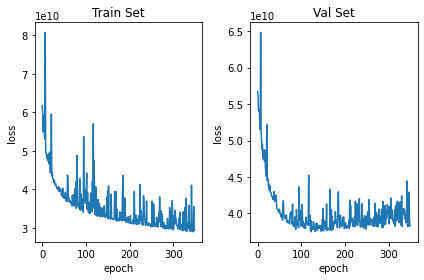

Best R Squared seen on epoch 221: 0.8804
Best MAE seen on epoch 172: 140122.67
Best-R2-model with R2 above min_save_r2=0.86 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8803
	Validation MAE: 140122.67
	Epoch seen: 172
	Model file: epoch=172,r2=0.8803,mae=140122,Invalids=0.pth
Best-MAE-model with MAE below max_save_mae=150000 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8803
	Validation MAE: 140122.67
	Epoch seen: 172
	Model file: epoch=172,r2=0.8803,mae=140122,Invalids=0.pth


In [16]:
train_set, val_set = data_sets["train"], data_sets["val"]      
train_X, train_bottleneck_X, train_y = train_set["X"], train_set["bottleneck_X"], train_set["y"]
val_X, val_bottleneck_X, val_y = val_set["X"], val_set["bottleneck_X"], val_set["y"]
input_size = train_X.shape[-1]
output_size = 3  # 3 means we have an intercept

### Tune Params Below ###
hidden_size = 32
final_point_only = True
num_layers = 1
dropout = 0
batch_size = 1024
learning_rate = .003
weight_decay = .01
loss_function = mse_loss_l1_coeff_reg
MEF_reg_weight, MDF_reg_weight = 1e7, 1e7
model_dir_prefix = "predict_final_in_seq8_BN"
epochs = 400
min_save_r2 = .86
max_save_mae = 150000
print_freq=20
# evaluate
save_model_path = train_model_with_params_batched(train_X, val_X, train_bottleneck_X, val_bottleneck_X, train_y, val_y,  # data
                            input_size, hidden_size, output_size, final_point_only, num_layers, dropout,  # model settings
                            learning_rate, weight_decay,  # optimizer settings
                            loss_function, MEF_reg_weight, MDF_reg_weight,  # loss function settings
                            model_dir_prefix, batch_size, epochs, print_freq, min_save_r2, max_save_mae)

In [34]:
train_y.shape

torch.Size([14443, 8])

In [78]:
final_point_only = False
train_set, val_set = data_sets["train"], data_sets["val"]      
train_X, train_bottleneck_X, train_y = train_set["X"], train_set["bottleneck_X"], train_set["y"]
val_X, val_bottleneck_X, val_y = val_set["X"], val_set["bottleneck_X"], val_set["y"]

if final_point_only:
    train_bottleneck_X = torch.unsqueeze(train_bottleneck_X[:,-1,:], 1)
    val_bottleneck_X = torch.unsqueeze(val_bottleneck_X[:,-1,:], 1)
    train_y = torch.unsqueeze(train_y[:,-1], 1)
    val_y = torch.unsqueeze(val_y[:,-1], 1)

model = LSTM(input_size, hidden_size, output_size, final_point_only, num_layers, dropout)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# tell model we are training
model.train()
train_pred_coeff = model(train_X.float())

In [79]:
train_pred_coeff.shape

torch.Size([14443, 8, 3])

In [80]:
train_pred_coeff[0]

tensor([[-0.0821,  0.0328,  0.0419],
        [-0.1009,  0.0313,  0.0490],
        [-0.1116,  0.0303,  0.0497],
        [-0.1230,  0.0308,  0.0537],
        [-0.1195,  0.0267,  0.0574],
        [-0.1183,  0.0274,  0.0567],
        [-0.1202,  0.0226,  0.0591],
        [-0.1184,  0.0256,  0.0556]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [82]:
y_pred = get_y_pred(train_pred_coeff, train_bottleneck_X)

In [83]:
y_pred.shape

torch.Size([14443, 8])

In [84]:
train_y.shape

torch.Size([14443, 8])

In [85]:
y_pred[0]

tensor([104.5600,  93.8499,  66.5238,  31.8933,  -4.7518, -59.5235, -92.0250,
         30.1953], device='cuda:0', grad_fn=<SelectBackward0>)

In [87]:
train_y[0]

tensor([-337029.7812, -243021.8281, -144846.7969,  -24776.5703,   49254.1367,
          88759.6875, 1101974.1250, -860734.4375], device='cuda:0')

In [63]:
loss = nn.MSELoss()(y_pred, train_y)


In [64]:
loss

tensor(3.0439e+11, device='cuda:0', grad_fn=<MseLossBackward0>)

## Inference on all data

In [102]:
## below we can load specific models instead of best one found in most recent experiment
model_path= "drive/MyDrive/NN_MEFs/lstm_models/predict_all_in_seq8/2022_12_08-12:36:39_AM/epoch=998,r2=0.8741,Invalids=0.pth"

train_set, val_set = data_sets["train"], data_sets["val"]      
train_X, train_bottleneck_X, train_y = train_set["X"], train_set["bottleneck_X"], train_set["y"]
val_X, val_bottleneck_X, val_y = val_set["X"], val_set["bottleneck_X"], val_set["y"]
input_size = train_X.shape[-1]
output_size = 3  # 3 means we have an intercept
hidden_size = 32
final_point_only = False
num_layers = 1
dropout = 0

model = LSTM(input_size, hidden_size, output_size, final_point_only, num_layers, dropout)
model.to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

train_pred_coeff = model(train_X.float())
val_pred_coeff = model(val_X.float())


In [103]:
train_y_pred = get_y_pred(train_pred_coeff, train_bottleneck_X)

In [112]:
train_y_pred.shape

torch.Size([14443, 8])

In [113]:
r2_score(train_y.cpu().detach().numpy(), train_y_pred.cpu().detach().numpy())

0.8834384493448952

In [116]:
[r2_score(y, y_pred) for y, y_pred in \
 zip(train_y.permute(1,0).cpu().detach().numpy(), train_y_pred.permute(1,0).cpu().detach().numpy())]

[0.8529343380942997,
 0.8696363903200108,
 0.8795923203147114,
 0.8862990346813329,
 0.8909820117950451,
 0.8939545501303765,
 0.8963344742449033,
 0.897774475458195]

In [117]:
val_y_pred = get_y_pred(val_pred_coeff, val_bottleneck_X)
print(f"overall val r2: {r2_score(val_y.cpu().detach().numpy(), val_y_pred.cpu().detach().numpy())}")
print("val r2 by sequence position:")
print([r2_score(y, y_pred) for y, y_pred in \
 zip(val_y.permute(1,0).cpu().detach().numpy(), val_y_pred.permute(1,0).cpu().detach().numpy())])

overall val r2: 0.8741031307517685
val r2 by sequence position:
[0.8568319386070357, 0.8682907729195138, 0.8745469021399369, 0.8777426423604695, 0.8794796853834416, 0.8781586552040923, 0.8787055918233209, 0.8790688571549825]


In [ ]:
hidden_dims = [512,256]
bias_term = True
dropout_p = 0.5
n_input = train_x.shape[1]


model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

print("R Squared:")
print(f"\tTrain: {get_r_squared(train_pred_coeff, CAISO_train, bias_term):.4f}")
print(f"\tVal: {get_r_squared(val_pred_coeff, CAISO_val, bias_term):.4f}")
print(f"\tTest: {get_r_squared(test_pred_coeff, CAISO_test, bias_term):.4f}")
print("Mean Absolute Error:")
print(f"\tTrain: {get_mean_abs_err(train_pred_coeff, CAISO_train, bias_term):.2f}")
print(f"\tVal: {get_mean_abs_err(val_pred_coeff, CAISO_val, bias_term):.2f}")
print(f"\tTest: {get_mean_abs_err(test_pred_coeff, CAISO_test, bias_term):.2f}")
print("Count Invalid Values Predicted:")
invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
invalid_test_MEFs, invalid_test_MDFs = get_count_invalid_preds(test_pred_coeff)
print(f"\tTrain: Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
print(f"\tVal: Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
print(f"\tTest: Invalid MEFs={invalid_test_MEFs}, Invalid MDFs={invalid_test_MDFs}")


R Squared:
	Train: 0.8921
	Val: 0.8805
	Test: 0.8755
Mean Absolute Error:
	Train: 131028.76
	Val: 140016.71
	Test: 139890.26
Count Invalid Values Predicted:
	Train: Invalid MEFs=0, Invalid MDFs=0
	Val: Invalid MEFs=0, Invalid MDFs=0
	Test: Invalid MEFs=0, Invalid MDFs=0


### Put the MEFs and MDFs from all sets back together and in order into the original DF for viewing

In [ ]:
all_preds_w_timestamps = list(zip(CAISO_val.index, val_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_train.index, train_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_test.index, test_pred_coeff.detach().numpy()))
all_preds_w_timestamps.sort(key=lambda pair: pair[0])
all_preds_ordered = np.array([pair[1] for pair in all_preds_w_timestamps])

In [ ]:
all_MEFs_ordered = all_preds_ordered[:,0]
all_MDFs_ordered = all_preds_ordered[:,1]
all_intercepts_ordered = all_preds_ordered[:,2]

In [ ]:
CAISO_Data.loc[:,"MEF"] = all_MEFs_ordered
CAISO_Data.loc[:,"MDF"] = all_MDFs_ordered
if bias_term:
    CAISO_Data.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = CAISO_Data.loc[:,'MEF'] * CAISO_Data.loc[:,'delta_Load'] \
            + CAISO_Data.loc[:,'MDF'] * CAISO_Data.loc[:,'delta_VRE']
if bias_term:
    d_emissions += CAISO_Data.loc[:,"Intercept"]
CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
CAISO_Data.loc[:,'Error']=CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
CAISO_Data.loc[:,'%_Error']=np.abs(CAISO_Data.loc[:,'Error'])/np.abs(CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
print("Whole Data Set:")
print(f"\tMean Emissions Change = {np.mean(np.abs(CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
print(f"\tR Squared = {r2_score(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.2f}")

Whole Data Set:
	Mean Emissions Change = 413165.73
	R Squared = 0.8864
	Mean Absolute Error = 134598.78


In [ ]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,Day_of_Week=3,Day_of_Week=4,Day_of_Week=5,Day_of_Week=6,MEF,MDF,Intercept,Predicted_delta_Total_CO2_Emissions,Error,%_Error
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,...,False,False,False,False,370.729431,-350.030640,6396.021973,-459526.000872,-122496.206729,0.363458
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,...,False,False,False,False,345.051025,-323.291504,6071.847168,-304454.710093,-61432.876394,0.252787
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,...,False,False,False,False,323.416351,-301.258514,5678.250977,-172189.482236,-27342.684733,0.188770
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,...,False,False,False,False,305.443024,-282.996887,5341.076660,-55190.639304,-30414.069545,1.227534
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,...,False,False,False,False,303.949066,-272.057770,5023.662109,26216.649928,-23037.486613,0.467727


In [ ]:
CAISO_Data.to_csv(f"{best_model_dir}/CAISO_Data_2019_2021_NN_Ts.with_coeff_preds.csv")

In [ ]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val <=0])

0

In [ ]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val >600])

53

In [ ]:
CAISO_Data.loc[:,"MEF"].max()

719.43835